# Introduction 
Originally, staking cryptocurrencies is a process that involves committing your crypto assets to support a blockchain network relying on a proof-of-stake model to process payment and confirm transactions. 
Staking essentially locks the coin in a smart contract, where the duration of the lock can be flexible (able to withdraw anytime) or fixed(time-locked). To incentivize users to stake, staking rewards are usually given in the native coin based on a predetermined APR/APY (which can be thought as interest accrued)

However, it has since been bastardized into a more generic form where most coin uses this staking mechanism in order to reduce the available supply of coins in circulation, which in theory should make the price of the coin trend up in the short term when the supply < demand, but eventually the price will trend down due to increased sell pressure from the staking rewards. 

# Scenario
To allow a user to calculate their potential gain/loss, we use a few simple assumptions.

Assume a coin's price fluctuates every day according to the equation: 
$$P_{m+1} = P_m + \Delta P$$

Where $P_{m+1}$ is the price of coin the following day, $P_m$ is the price of coin currently, and $\Delta P$ is the change in coin price, which will be extracted (via Metropolis-Hastings) from the probability density function given below:
$$ \frac{1}{(p+2)^4+1} + \frac{0.4}{p^2+1} + \frac{0.8}{(p-2)^4+1} $$


# Goal
Calculate average gain, $<Gain>$ for user after three months (90 days) of staking up to their specified tolerance level using the formula:

$$ Gain = P(3 months) - P(0) + Gain_{staking} $$

$P(3 months)$ = value of coins after 3 months, $P(0)$ = initial value of coins, $Gain_{staking}$ =  Gain from staking

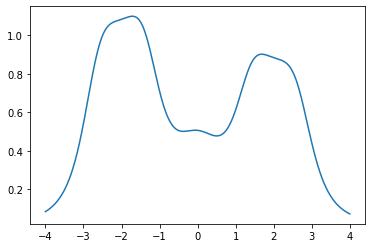

In [32]:
import numpy as np
import matplotlib.pyplot as plt


p = np.linspace(-4,4,1000)
y= lambda p: (1/((p+2)**4+1)) + (0.4/(p**2+1)) + (0.8/((p-2)**4+1)) #probability density function
plt.plot(p,y(p))
plt.show()

# plot of density function, higher probability of it being negative than positive,
# which means that the price is more likely to trend down than up

In [33]:
# Using Metropolis-Hastings to extract 
def metropolisHastingMarkovChain(probFunct, xAxis, startingPoint, varianceProposalDensity, numberOfExtractions):
    """
    Produces a Markov Chain with probability density propotional to probFunct
    It will be produced with the Metropolis Hasting algorithm 
    It uses a normal distribution with a variance varianceProposalDensity
    
    Parameters
        ----------
        probFunct     : function
            function of one variable proportional to the intended distribution
        startingPoint : float
            initial point for the Markov Chain
        varianceProposalDensity : float
            variance of the normal distribution used as proposal density
        numberOfExtractions : int
            Number of extractions for the Markov chain
            
    Returns
        ----------
        markovChain : numpy array
            returned Markov chain
    """
    
    for nExtr in range(int(0.15*numberOfExtractions)):
        candidate = np.random.default_rng().normal(startingPoint, varianceProposalDensity, 1)
        if (np.random.rand() <= probFunct(candidate) / probFunct(startingPoint)):
            startingPoint = candidate
            
    markovChain = np.array([startingPoint])
    for nExtr in range(numberOfExtractions-1):
        candidate = np.random.default_rng().normal(markovChain[-1], varianceProposalDensity, 1)
        if (np.random.rand() <= probFunct(candidate) / probFunct(markovChain[-1])):
            markovChain = np.append(markovChain,candidate)
        else:
            markovChain = np.append(markovChain,markovChain[-1])
    markovChain = markovChain[ (markovChain >= min(xAxis)) & (markovChain <= max(xAxis)) ] 
    # only returns values that are within the possible price changes  
    print('markov chain has', len(markovChain), 'entries') #to check that we did not remove too much data
    
    return markovChain    


In [34]:
# function to generate random deltaP, since taking numbers consecutively from markovChain would mean 
# that the numbers are correlated, which is not what we want for a random fluctuation in price.

def getDeltaP(markovChain,interval):
    '''this generates DeltaP by picking randomly from the markovChain based on the interval
    Parameters
        ----------
        markovChain: numpy array
            numpy array extracted from probability density function
        interval:  int
            Number of times to pick randomly from markovChain
            
    Returns
        ----------
        deltaP : numpy array
            randomised deltaP'''
    i = 0 
    deltaP = []
    while i <= interval:  
        deltaP = np.append(deltaP, markovChain[np.random.randint(0,len(markovChain))])
        i += 1
    return deltaP


In [35]:
# this has no graph 
def averageGain(initPrice, initAmtCoin, days, APY, tolerance):
    '''this calculates the average gains for the user based on the parameters given
        ----------
        initPrice: float
            initial price of coin
        initAmtCoin: float
            amount of coins user posses initially
        days:  float
            Number of days staked
        APY: float
            APY for staking, written as decimal point
        tolerance: float
            tolerance level for average coin price calculated after days staked
            
    Returns
        ----------
        A statement telling the user their average gain after staking'''
        
    finalPriceAllLoops = []
    m = 0
    error = 10*tolerance
    initWorth = (initPrice)*(initAmtCoin)
    
    while error > tolerance:
        deltaP = getDeltaP(result,days)
        finalPriceOneLoop = initPrice + np.sum(deltaP)
        m += 1
        if m <= 1:
            finalPriceAllLoops = np.append(finalPriceAllLoops,finalPriceOneLoop)
        else: 
                avgOldP = np.sum(finalPriceAllLoops)/(m-1)
                finalPriceAllLoops = np.append(finalPriceAllLoops,finalPriceOneLoop)
                avgNewP = np.sum(finalPriceAllLoops)/m
                error =  abs(avgOldP - avgNewP)


    # averageGain = P3months * Coin amount(original + reward from staking) - P0 * coin amount(original)
    averageGain = (avgNewP)*(initAmtCoin)*(1 + APY *days/365) - initWorth
    print( 'The average gain after staking is $%f, average price of coin after staking is $%f'%(averageGain,avgNewP))
    percentGain = '{:.2%}'.format(averageGain/initWorth)
    print('this translates to a', percentGain, 'gain')
    

In [ ]:
#bonus for conclusion, has graph

def averageGain(initPrice, initAmtCoin, days, APY, tolerance):
    '''this calculates the average gains for the user based on the parameters given
        ----------
        initPrice: float
            initial price of coin
        initAmtCoin: float
            amount of coins user posses initially
        days:  float
            Number of days staked
        APY: float
            APY for staking, written as decimal point
        tolerance: float
            tolerance level for average coin price calculated after days staked
            
    Returns
        ----------
        A statement telling the user their average gain after staking'''
        
    finalPriceAllLoops = []
    m = 0
    error = 10*tolerance
    initWorth = (initPrice)*(initAmtCoin)
    
    
    
    while error > tolerance:
        deltaP = getDeltaP(result,days)
        finalPriceOneLoop = initPrice + np.sum(deltaP)
        n = 0
        p= []
        p0 = initPrice
        for i in deltaP:
            p0 = p0 + deltaP[n]
            p = np.append(p,p0)
            n +=1
        m += 1
        if m <= 1:
            finalPriceAllLoops = np.append(finalPriceAllLoops,finalPriceOneLoop)
            pLooped = p
        else: 
                avgOldP = np.sum(finalPriceAllLoops)/(m-1)
                finalPriceAllLoops = np.append(finalPriceAllLoops,finalPriceOneLoop)
                avgNewP = np.sum(finalPriceAllLoops)/m
                error =  abs(avgOldP - avgNewP)
                pLooped += p 
    
    priceEachDay = pLooped/m
    d = np.append(np.array(0), np.linspace(1,days,days))
    coinWorth = (priceEachDay)*(initAmtCoin)*(1 + APY *days/365)
    plt.plot(d,coinWorth, label = '$ value of coins')
    plt.hlines(initWorth, 0, days, colors = 'red', linestyles = 'dashed', linewidth = 2, label = 'initial $ value of coins')
    plt.xlabel('Days staked')
    plt.ylabel('$ value of coins')
    plt.legend()
    plt.show()


    # averageGain = P3months * Coin amount(original + reward from staking) - P0 * coin amount(original)
    averageGain = (avgNewP)*(initAmtCoin)*(1 + APY *days/365) - initWorth
    print( 'The average gain after staking is $%f, average price of coin after staking is $%f'%(averageGain,avgNewP))
    percentGain = '{:.2%}'.format(averageGain/initWorth)
    print('this translates to a', percentGain, 'gain')
    
averageGain(125, 10235, 105, 0.4, 0.001)

# The following codes are essentially functions to generate user input on various parameters with some handling of common errors

In [36]:
def userInputPriceChange():
    x = True
    while x == True:
        try:
            minMaxPriceChange = abs(float(eval(input("Minimum/Maximum of coin price change(one numerical value only, will be used for max(+ve) and min(-ve)) = "))))
            x = False
        except (ValueError, NameError):
            print("please follow instructions or this will keep looping :)")
            testing()
        except ZeroDivisionError:
            print('Error! Why are you even dividing by zero? Try again')
            testing()
        except Exception as error:
            print(error)
    
    return minMaxPriceChange

def userInputInitPrice():
    x = True
    while x == True:
        try:
            initPrice = abs(float(eval(input("Initial price of coin (numbers only please)  = "))))
            x = False
        except (ValueError, NameError):
            print("please follow instructions or this will keep looping :)")
            testing()
        except ZeroDivisionError:
            print('Error! Why are you even dividing by zero? Try again')
            testing()
        except Exception as error:
            print(error)
    
    return initPrice

def userInputInitCoin():
    x = True
    while x == True:
        try:
            initCoin = abs(float(eval(input("Initial amount of coin (numbers only please)  = "))))
            x = False
        except (ValueError, NameError):
            print("please follow instructions or this will keep looping :)")
            testing()
        except ZeroDivisionError:
            print('Error! Why are you even dividing by zero? Try again')
            testing()
        except Exception as error:
            print(error)
    
    return initCoin

def userInputDays():
    x = True
    while x == True:
        try:
            days = abs(float(eval(input("Days staked (numbers only please) = "))))
            x = False
        except (ValueError, NameError):
            print("please follow instructions or this will keep looping :)")
            testing()
        except ZeroDivisionError:
            print('Error! Why are you even dividing by zero? Try again')
            testing()
        except Exception as error:
            print(error)
    
    return days

def userInputAPY():
    x = True
    while x == True:
        try:
            APY = 0.01*abs(float(eval(input("APY for staking (numbers only please)  = "))))
            x = False
        except (ValueError, NameError):
            print("please follow instructions or this will keep looping :)")
            testing()
        except ZeroDivisionError:
            print('Error! Why are you even dividing by zero? Try again')
            testing()
        except Exception as error:
            print(error)
    
    return APY

def userInputTolerance():
    x = True
    while x == True:
        try:
            tolerance = abs(float(eval(input("Tolerance level on the average price of coin after X days staked (numerical decimal only please)  = "))))
            if tolerance <= 0.000001:
                print('Tolerance level will require large amount of computing power for minimal benefits, try a larger tolerance instead')
            else:
                x = False
        except (ValueError, NameError):
            print("please follow instructions or this will keep looping :)")
        except ZeroDivisionError:
            print('Error! Why are you even dividing by zero? Try again') 
        except Exception as error:
            print(error)
    
    return tolerance


# How it works (simplified version)

The simpleCalcAvgGain() function works by using a predetermined set of parameters, only asking the user for their input on the tolerance level on the average price of coin after 90 days staked.

The program works like this:
1. The markov chain is generated via the metropolisHastingMarkovChain() function, the inputs are chosen without the need to ask the user for their input. 
2. avgGains() is called to calculate average gains, this is done via a while loop which only stops when error is <= tolerance. In each iteration, getDeltaP() function is called, which generates a randomised array of 90 elements (deltaP) using the same markov chain. This gives us the price action for the next 90 days, which can be summed and then added to the initial price of coin (initPrice) to give final price of coin (FinalCoinOneLoop)
3. This process is repeated and in each iteration the FinalCoinOneLoop is different and summed together, divided by the total amount of times looped. This produces the average price of coin after 90 days of staking. The process finally ends when difference between the average price of coin after 90 days of staking between two consecutive loops is lesser than tolerance set by user.

Tolerance level on the average price of coin after X days staked (numerical decimal only please)  = 0.001
markov chain has 9639 entries


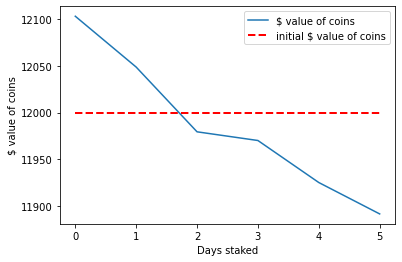

The average gain after staking is $-108.415200, average price of coin after staking is $117.674623
this translates to a -0.90% gain


In [53]:
def simpleCalcAvgGain():
    # only gets user's input on tolerance, rest of the parameters are preset; useful as an example
    pChange = np.linspace(-4,4,1000) #creates the x axis for price change
    initPrice = 120
    initAmtCoin = 100
    days = 5
    APY = 0.77
    tolerance = userInputTolerance()    
      
    # generate markov chain
    numberOfExtractions = 10000 
    global result
    result = metropolisHastingMarkovChain(y, pChange, np.mean(pChange), 0.33*(abs(min(pChange)) + max(pChange)), numberOfExtractions)
    
    # generate average gains according to user inputs
    avgGains = averageGain(initPrice, initAmtCoin, days, APY, tolerance)
    
    return avgGains

simpleCalcAvgGain()

# Normal Version
For this function calcAvgGain(), it works the same way as the previous function, the only exception is that here the user is free to enter their own parameters for the variables.


In [31]:


def calcAvgGain():
    # get all the user inputs
    pc = userInputPriceChange()
    pChange = np.linspace(-pc,pc,1000) #creates the x axis for price change
    initPrice = userInputInitPrice()
    initAmtCoin = userInputInitCoin()
    days = userInputDays()
    APY = userInputAPY()
    tolerance = userInputTolerance()
    
    
    #generate markov chain
    numberOfExtractions = 10000 
    global result
    result = metropolisHastingMarkovChain(y, pChange, np.mean(pChange), 0.33*(abs(min(pChange)) + max(pChange)), numberOfExtractions)
    
    #generate average gains according to user inputs
    avgGains = averageGain(initPrice, initAmtCoin, days, APY, tolerance)
    
    return avgGains

calcAvgGain()

Minimum/Maximum of coin price change(one numerical value only, will be used for max(+ve) and min(-ve)) = 8
Initial price of coin (numbers only please)  = 177
Initial amount of coin (numbers only please)  = 1236573
Days staked (numbers only please) = 189
APY for staking (numbers only please)  = 67
Tolerance level on the average price of coin after X days staked (numerical decimal only please)  = 0.0001
markov chain has 9876 entries
The average gain after staking is $17091804.802931, average price of coin after staking is $141.671579
this translates to a 7.81% gain


# Conclusion
This is a simple model, but it does gives the user some basic insight on what their potential gain/loss would be. When given a particular APY, the user can vary the days staked parameter and see at which day they would break-even or even profit on average, which would allow them to consider the risks and choose if they should stake or not. 